In [ ]:
# %%

import logging
import os

In [ ]:
# %% Init logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

EXPORT_PGF = False

In [ ]:
# %%

def isnotebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == "ZMQInteractiveShell":
            return True  # Jupyter notebook or qtconsole
        elif shell == "TerminalInteractiveShell":
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False


# If notebook set the root path to the parent directory
if isnotebook():
    import sys
    from pathlib import Path

    current_path = Path(__file__).resolve()
    root_path = current_path.parent.parent
    sys.path.append(str(root_path))

In [ ]:
# %%

from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cycler import cycler
from matplotlib import font_manager as fm
from tbparse import SummaryReader

In [ ]:
# %% Seaborn plot style

# sns.set_theme(style="darkgrid", palette="muted", color_codes=True)

# ['gtk3agg', 'gtk3cairo', 'gtk4agg', 'gtk4cairo', 'macosx', 'nbagg', 'notebook', 'qtagg', 'qtcairo', 'qt5agg', 'qt5cairo', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wxagg', 'wxcairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template', 'inline']
if not isnotebook():
    if os.name == "posix" and "DISPLAY" not in os.environ:
        matplotlib.use("WebAgg")
    else:
        try:
            matplotlib.use("Qt5Agg")
        except ImportError:
            matplotlib.use("WebAgg")
    matplotlib.use("WebAgg")
else:
    try:
        matplotlib.use("ipympl")
    except ImportError:
        matplotlib.use("notebook")

print(f"Using matplotlib backend: {matplotlib.get_backend()}")

# RUB Colors
red = np.array((198, 77, 50), dtype=float) * (1 / 255)
green = np.array((148, 193, 27), dtype=float) * (1 / 255)
blue = np.array((0, 53, 96), dtype=float) * (1 / 255)
orange = np.array((228, 136, 65), dtype=float) * (1 / 255)
gray = np.array((221, 221, 221), dtype=float) * (1 / 255)
rub_colors = [
    tuple(blue),
    tuple(green),
    tuple(orange),
    tuple(red),
    tuple(gray),
]
matplotlib.rcParams["axes.prop_cycle"] = cycler(color=rub_colors)
plt.xkcd()
font_path = "/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf"
prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = prop.get_name()


if EXPORT_PGF:
    matplotlib.use("pgf")
    matplotlib.rcParams.update(
        {
            "pgf.texsystem": "pdflatex",
            "font.family": "serif",
            "text.usetex": True,
            "pgf.rcfonts": False,
        }
    )
else:
    matplotlib.rcParams.update(
        {
            "text.usetex": False,
            "svg.fonttype": "none",
        }
    )

Using matplotlib backend: ipympl


In [ ]:
# %%

ROOT_PATH = Path(__file__).parents[1]
export_tex = True
TB_VERSION_INDEX = 0  # -1

In [ ]:
# %%

OUTPUT_SUPATH = ROOT_PATH / "logs" / "tensorboard"
experiments = OUTPUT_SUPATH.glob("*")

# Get all sub folders of the tensorboard folder
tb_folders = {
    exp.name: exp
    for exp in experiments
    if exp.is_dir() and not exp.name.startswith(".")
}

tb_data: dict[str, dict[str, dict[str, pd.DataFrame]]] = {
    "scalars": {},
    "hparams": {},
    "text": {},
}

for name, tb_folder in tb_folders.items():
    # Get the newest version_*
    versions = sorted(
        [
            exp
            for exp in tb_folder.glob("version_*")
            if exp.is_dir() and not exp.name.startswith(".")
        ],
        key=lambda x: int(x.name.split("_")[-1]),
    )

    reader = SummaryReader(versions[-1])
    tb_data["scalars"][name] = reader.scalars.pivot_table(
        index="step", columns="tag", values="value"
    )
    tb_data["hparams"][name] = reader.hparams
    tb_data["text"][name] = reader.text

In [ ]:
# %% Read in benchmark results

benchmark_results = pd.read_csv(
    ROOT_PATH / "logs" / "benchmark_results.csv", index_col=0
)

benchmark_results

,Dataset,Time (s),Speed (samples/s)
1,TensorDictMemmapDataset,29.17,7688.19
2,NumpyMemmapDataset,34.41,5524.05
4,DaliNumpyPipeline,46.54,3020.63
6,DaliNumpyExternalPipeline,51.67,2450.42
3,DaliAudioPipeline,61.51,1729.21
0,TorchAudioDataset,76.34,1122.48
5,WebDataset,120.86,447.82


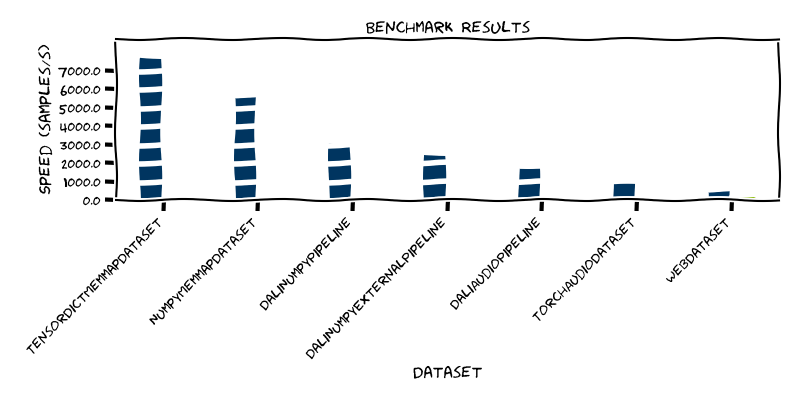

In [ ]:
# %% Bar Chart

fig, ax = plt.subplots(figsize=(8, 4))
benchmark_results = benchmark_results.sort_values(
    by="Speed (samples/s)", ascending=False
)
benchmark_results["Speed (samples/s)"] = benchmark_results["Speed (samples/s)"].round(2)
benchmark_results["Time (s)"] = benchmark_results["Time (s)"].round(2)
benchmark_results = benchmark_results[
    ["Dataset", "Speed (samples/s)", "Time (s)"]
].set_index("Dataset")
benchmark_results.plot(
    kind="bar",
    ax=ax,
    color=[blue, green],
    title="Benchmark Results",
    xlabel="Dataset",
    ylabel="Speed (samples/s)",
    legend=False,
)
ax.set_xticklabels(
    benchmark_results.index,
    rotation=45,
    ha="right",
    fontsize=10,
)
ax.set_yticks(
    np.arange(0, benchmark_results["Speed (samples/s)"].max() + 1, 1000),
)
ax.set_yticklabels(
    np.arange(0, benchmark_results["Speed (samples/s)"].max() + 1, 1000),
    fontsize=10,
)
ax.set_ylim(
    0,
    benchmark_results["Speed (samples/s)"].max() + 1000,
)
ax.set_title("Benchmark Results", fontsize=12)
ax.set_xlabel("Dataset", fontsize=12)
ax.set_ylabel("Speed (samples/s)", fontsize=12)
ax.grid()
fig.tight_layout()
fig.show()

In [ ]:
# %% Plot computation time

def plot_metric(
    metric_key="train_epoch_time",
    ylabel="Time (s)",
    title="Computation time",
    figsize=(8, 4),
):
    fig, ax = plt.subplots(figsize=figsize)
    for name, data in tb_data["scalars"].items():
        if metric_key in data.columns:
            data = data[[metric_key]]
            data = data.rename(columns={metric_key: name})
            data = data.reset_index()
            # data["step"] = data["step"] / 1000

            values = data[name].to_numpy()
            values = (
                pd.Series(values).rolling(window=3, min_periods=1).mean().to_numpy()
            )
            mask = np.isfinite(values)

            ax.plot(data["step"].to_numpy()[mask], values[mask], label=name)

    ax.set_xlabel("Step")
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # Legend below the plot
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        fancybox=True,
        shadow=True,
        ncol=3,
        fontsize=10,
    )

    ax.grid()

    fig.tight_layout()
    fig.show()

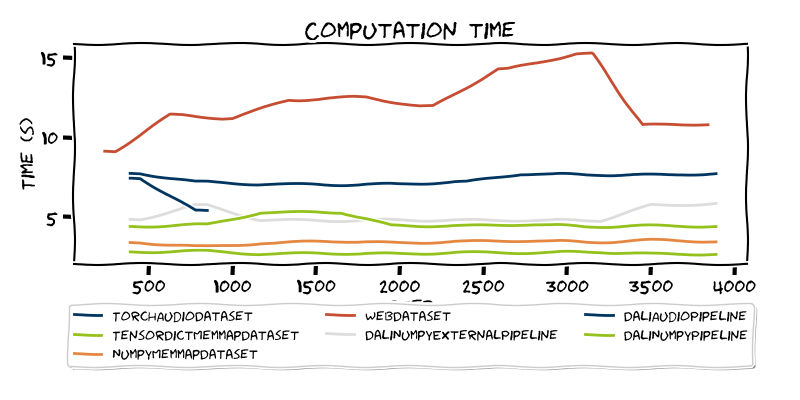

In [ ]:
# %%

plot_metric()

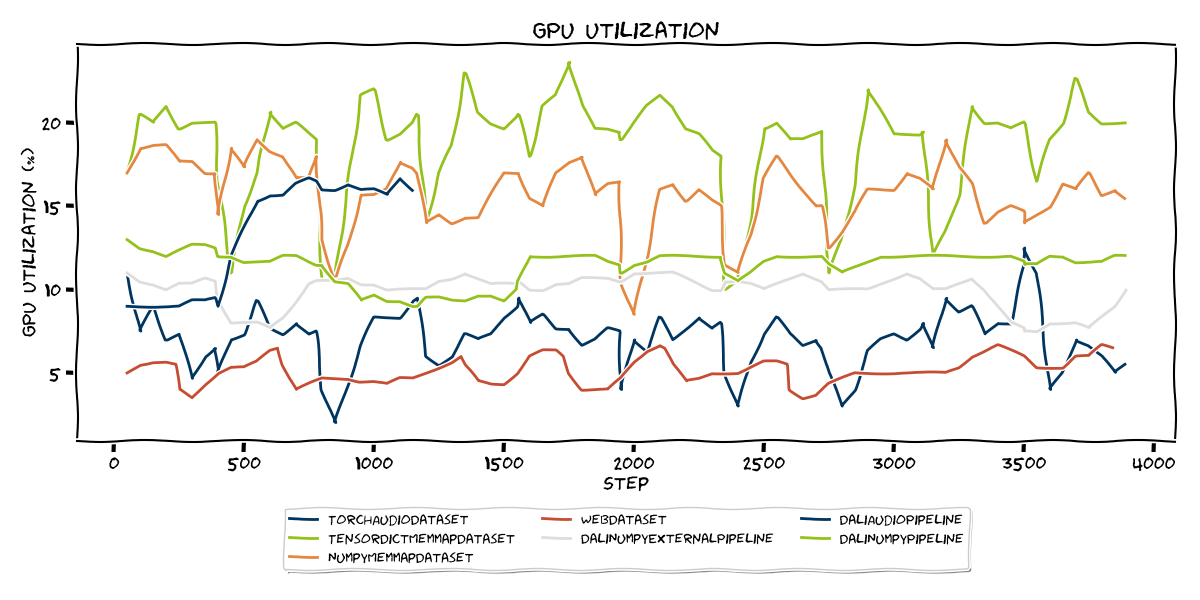

In [ ]:
# %%

plot_metric(
    metric_key="gpu_utilization",
    ylabel="GPU Utilization (%)",
    title="GPU Utilization",
    figsize=(12, 6),
)

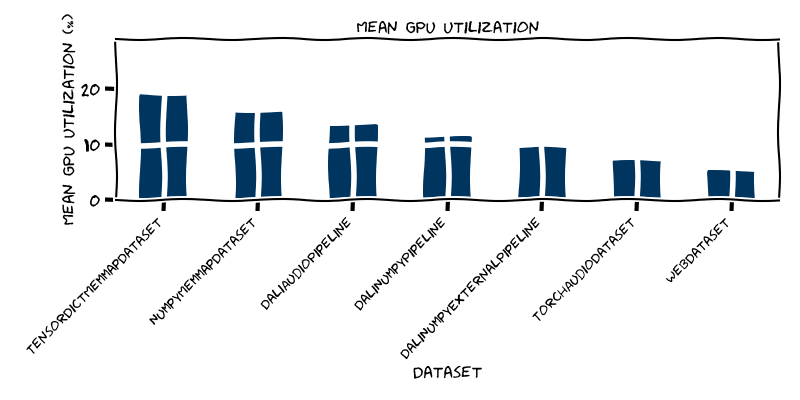

In [ ]:
# %% Bar chart of mean gpu utilization

metric_key = "gpu_utilization"
fig, ax = plt.subplots(figsize=(8, 4))
df = pd.DataFrame(
    {
        name: data[metric_key].mean()
        for name, data in tb_data["scalars"].items()
        if metric_key in data.columns
    },
    index=[0],
).T
df.columns = ["Mean GPU Utilization (%)"]
df = df.sort_values(by="Mean GPU Utilization (%)", ascending=False)
df.plot(
    kind="bar",
    ax=ax,
    color=[blue, green],
    title="Mean GPU Utilization",
    xlabel="Dataset",
    ylabel="Mean GPU Utilization (%)",
    legend=False,
)
ax.set_xticklabels(
    df.index,
    rotation=45,
    ha="right",
    fontsize=10,
)
ax.set_ylim(
    0,
    df["Mean GPU Utilization (%)"].max() + 10,
)
ax.set_title("Mean GPU Utilization", fontsize=12)
ax.set_xlabel("Dataset", fontsize=12)
ax.set_ylabel("Mean GPU Utilization (%)", fontsize=12)
ax.grid()
fig.tight_layout()
fig.show()

In [ ]:
# %%

pass